In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

CHECKPOINT-1: EDA & DATA PREPROCESSING

Dataset Overview:
   Normal X-rays: 514
   TB X-rays: 2494
   Total: 3008

Class Imbalance:
   Imbalance ratio: 4.85x
   Normal %: 17.1%
   TB %: 82.9%

Sample Images Shape: (224, 224, 3)


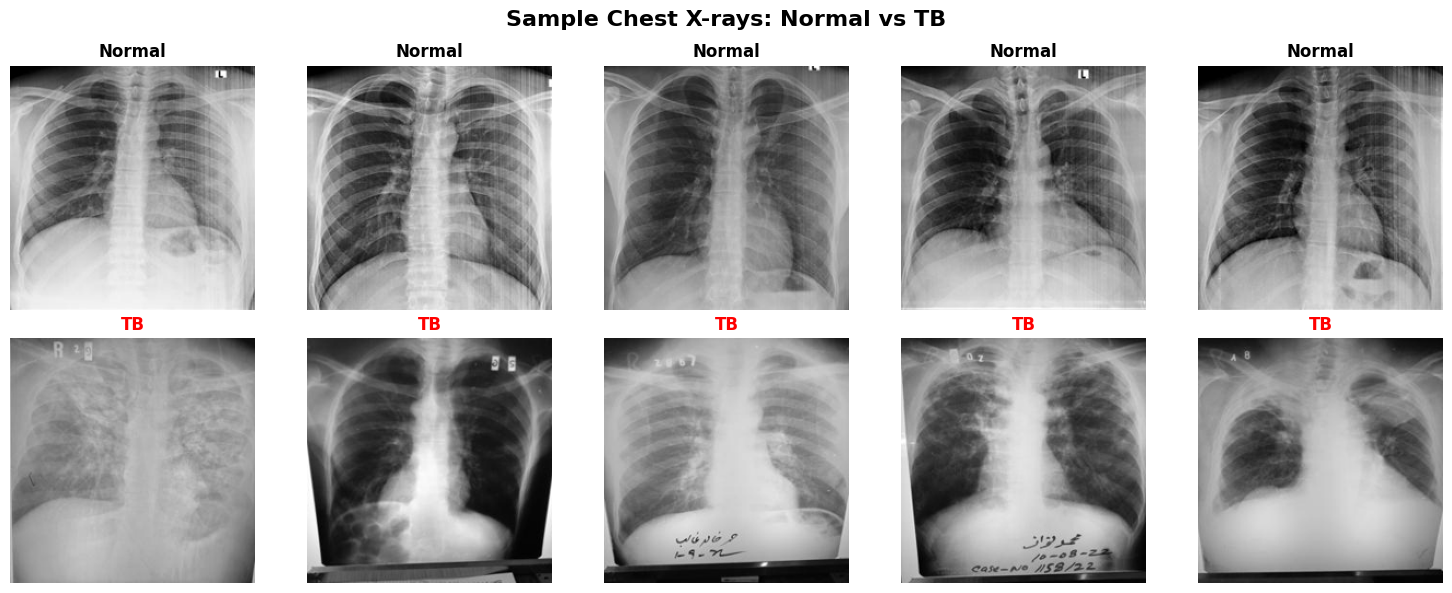


Summary Statistics (Sample):
   Normal - Mean pixel: 133.59, Std: 50.76
   TB - Mean pixel: 135.12, Std: 56.48


In [ ]:
print("="*70)
print("CHECKPOINT-1: EDA & DATA PREPROCESSING")
print("="*70)

data_dir = '/content/drive/MyDrive/ML dataset/Dataset of Tuberculosis Chest X-rays Images'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'TB')

normal_images = os.listdir(normal_dir)
tb_images = os.listdir(tb_dir)

print(f"\nDataset Overview:")
print(f"   Normal X-rays: {len(normal_images)}")
print(f"   TB X-rays: {len(tb_images)}")
print(f"   Total: {len(normal_images) + len(tb_images)}")

print(f"\nClass Imbalance:")
print(f"   Imbalance ratio: {len(tb_images)/len(normal_images):.2f}x")
print(f"   Normal %: {len(normal_images)/(len(normal_images)+len(tb_images))*100:.1f}%")
print(f"   TB %: {len(tb_images)/(len(normal_images)+len(tb_images))*100:.1f}%")

def load_images_from_dir(directory, label, img_size=224):
    images = []
    labels = []
    for filename in os.listdir(directory)[:50]:
        try:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((img_size, img_size))
            images.append(np.array(img))
            labels.append(label)
        except:
            pass
    return images, labels

normal_sample, normal_labels = load_images_from_dir(normal_dir, 0)
tb_sample, tb_labels = load_images_from_dir(tb_dir, 1)

print(f"\nSample Images Shape: {normal_sample[0].shape}")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Chest X-rays: Normal vs TB', fontsize=16, fontweight='bold')

for i in range(5):
    axes[0, i].imshow(normal_sample[i], cmap='gray')
    axes[0, i].set_title('Normal', fontweight='bold')
    axes[0, i].axis('off')

    axes[1, i].imshow(tb_sample[i], cmap='gray')
    axes[1, i].set_title('TB', fontweight='bold', color='red')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nSummary Statistics (Sample):")
print(f"   Normal - Mean pixel: {np.mean(normal_sample):.2f}, Std: {np.std(normal_sample):.2f}")
print(f"   TB - Mean pixel: {np.mean(tb_sample):.2f}, Std: {np.std(tb_sample):.2f}")

In [ ]:
print("\n" + "="*70)
print("DATA PREPARATION")
print("="*70)

IMG_SIZE = 224
BATCH_SIZE = 32

def load_all_images(directory, label, img_size=IMG_SIZE):
    images = []
    labels = []
    for filename in os.listdir(directory):
        try:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((img_size, img_size))
            images.append(np.array(img))
            labels.append(label)
        except:
            continue
    return np.array(images), np.array(labels)

print("\nLoading Normal images...")
normal_images_arr, normal_labels_arr = load_all_images(normal_dir, 0)

print("Loading TB images...")
tb_images_arr, tb_labels_arr = load_all_images(tb_dir, 1)

X = np.concatenate([normal_images_arr, tb_images_arr])
y = np.concatenate([normal_labels_arr, tb_labels_arr])

print(f"\nTotal dataset shape: {X.shape}")
print(f"Total labels shape: {y.shape}")

X = X.astype('float32') / 255.0
print("Images normalized to [0, 1]")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")
print(f"   Train - Normal: {np.sum(y_train==0)}, TB: {np.sum(y_train==1)}")
print(f"   Test - Normal: {np.sum(y_test==0)}, TB: {np.sum(y_test==1)}")

print("\nApplying Data Augmentation...")
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class_weight = {
    0: len(y_train) / (2 * np.sum(y_train == 0)),
    1: len(y_train) / (2 * np.sum(y_train == 1))
}

print(f"\nClass Weights:")
print(f"   Normal: {class_weight[0]:.3f}")
print(f"   TB: {class_weight[1]:.3f}")


DATA PREPARATION

Loading Normal images...
Loading TB images...

Total dataset shape: (3008, 224, 224, 3)
Total labels shape: (3008,)
Images normalized to [0, 1]

Train set: (2406, 224, 224, 3), Test set: (602, 224, 224, 3)
   Train - Normal: 411, TB: 1995
   Test - Normal: 103, TB: 499

Applying Data Augmentation...

Class Weights:
   Normal: 2.927
   TB: 0.603


In [ ]:
def build_resnet50_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model, "ResNet50"

In [ ]:
def build_vgg16_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = AveragePooling2D(pool_size=(4, 4))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model, "VGG16"

In [ ]:
def build_efficientnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model, "EfficientNetB0"

In [ ]:
print("\n" + "="*70)
print("CHECKPOINT-2: MODEL TRAINING & COMPARISON")
print("="*70)

models_dict = {}
histories_dict = {}
predictions_dict = {}
metrics_dict = {}


CHECKPOINT-2: MODEL TRAINING & COMPARISON


In [ ]:
print(f"\n{'='*70}")
print(f"Training ResNet50")
print(f"{'='*70}")

resnet_model, resnet_name = build_resnet50_model()

resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(),
             keras.metrics.Recall(),
             keras.metrics.AUC()]
)

print(f"{resnet_name} compiled!")
print(f"   Total parameters: {resnet_model.count_params():,}")

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)

print(f"\nTraining starting...")
resnet_history = resnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=25,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

resnet_pred_prob = resnet_model.predict(X_test, verbose=0)
resnet_pred = (resnet_pred_prob > 0.5).astype(int).flatten()

models_dict[resnet_name] = resnet_model
histories_dict[resnet_name] = resnet_history
predictions_dict[resnet_name] = {
    'y_pred': resnet_pred,
    'y_pred_prob': resnet_pred_prob.flatten()
}

print(f"{resnet_name} training completed!\n")


Training ResNet50
ResNet50 compiled!
   Total parameters: 24,112,513

Training starting...
Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 60s 585ms/step - accuracy: 0.4786 - auc: 0.4660 - loss: 0.7918 - precision: 0.8193 - recall: 0.4812 - val_accuracy: 0.1761 - val_auc: 0.8735 - val_loss: 0.7332 - val_precision: 1.0000 - val_recall: 0.0060 - learning_rate: 0.0010
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 396ms/step - accuracy: 0.4357 - auc: 0.5205 - loss: 0.7039 - precision: 0.8285 - recall: 0.4029 - val_accuracy: 0.3140 - val_auc: 0.8018 - val_loss: 0.6940 - val_precision: 1.0000 - val_recall: 0.1723 - learning_rate: 0.0010
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 391ms/step - accuracy: 0.4388 - auc: 0.5457 - loss: 0.7068 - precision: 0.8443 - recall: 0.3845 - val_accuracy: 0.8289 - val_auc: 0.7721 - val_loss: 0.5975 - val_precision: 0.8289 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 406ms/step - accuracy: 0.5112 - auc: 0.4951 - loss: 0.7022 - prec

In [ ]:
print(f"\n{'='*70}")
print(f"Training VGG16")
print(f"{'='*70}")

vgg_model, vgg_name = build_vgg16_model()

vgg_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(),
             keras.metrics.Recall(),
             keras.metrics.AUC()]
)

print(f"{vgg_name} compiled!")
print(f"   Total parameters: {vgg_model.count_params():,}")

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)

print(f"\nTraining starting...")
vgg_history = vgg_model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=25,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

vgg_pred_prob = vgg_model.predict(X_test, verbose=0)
vgg_pred = (vgg_pred_prob > 0.5).astype(int).flatten()

models_dict[vgg_name] = vgg_model
histories_dict[vgg_name] = vgg_history
predictions_dict[vgg_name] = {
    'y_pred': vgg_pred,
    'y_pred_prob': vgg_pred_prob.flatten()
}

print(f"{vgg_name} training completed!\n")


Training VGG16
VGG16 compiled!
   Total parameters: 14,846,273

Training starting...
Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 72s 693ms/step - accuracy: 0.6584 - auc_1: 0.6703 - loss: 0.6673 - precision_1: 0.8797 - recall_1: 0.6769 - val_accuracy: 0.8289 - val_auc_1: 0.9654 - val_loss: 0.4191 - val_precision_1: 1.0000 - val_recall_1: 0.7936 - learning_rate: 0.0010
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.8124 - auc_1: 0.8943 - loss: 0.4214 - precision_1: 0.9577 - recall_1: 0.8085 - val_accuracy: 0.7492 - val_auc_1: 0.9751 - val_loss: 0.5578 - val_precision_1: 1.0000 - val_recall_1: 0.6974 - learning_rate: 0.0010
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 452ms/step - accuracy: 0.8485 - auc_1: 0.9214 - loss: 0.3461 - precision_1: 0.9652 - recall_1: 0.8510 - val_accuracy: 0.8223 - val_auc_1: 0.9803 - val_loss: 0.4159 - val_precision_1: 1.0000 - val_recall_1: 0.7856 - learning_rate: 0.0010
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.8408 - auc

In [ ]:
print(f"\n{'='*70}")
print(f"Training EfficientNetB0")
print(f"{'='*70}")

eff_model, eff_name = build_efficientnet_model()

eff_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(),
             keras.metrics.Recall(),
             keras.metrics.AUC()]
)

print(f"{eff_name} compiled!")
print(f"   Total parameters: {eff_model.count_params():,}")

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)

print(f"\nTraining starting...")
eff_history = eff_model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=25,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

eff_pred_prob = eff_model.predict(X_test, verbose=0)
eff_pred = (eff_pred_prob > 0.5).astype(int).flatten()

models_dict[eff_name] = eff_model
histories_dict[eff_name] = eff_history
predictions_dict[eff_name] = {
    'y_pred': eff_pred,
    'y_pred_prob': eff_pred_prob.flatten()
}

print(f"{eff_name} training completed!\n")

print(f"\n{'='*70}")
print("ALL MODELS TRAINED SUCCESSFULLY!")
print(f"{'='*7}")


Training EfficientNetB0
EfficientNetB0 compiled!
   Total parameters: 4,377,764

Training starting...
Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 827ms/step - accuracy: 0.4678 - auc_2: 0.4694 - loss: 0.7554 - precision_2: 0.8101 - recall_2: 0.4646 - val_accuracy: 0.8289 - val_auc_2: 0.5000 - val_loss: 0.5442 - val_precision_2: 0.8289 - val_recall_2: 1.0000 - learning_rate: 0.0010
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 361ms/step - accuracy: 0.6016 - auc_2: 0.5104 - loss: 0.7264 - precision_2: 0.8374 - recall_2: 0.6423 - val_accuracy: 0.8289 - val_auc_2: 0.4970 - val_loss: 0.6017 - val_precision_2: 0.8289 - val_recall_2: 1.0000 - learning_rate: 0.0010
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 357ms/step - accuracy: 0.6209 - auc_2: 0.4950 - loss: 0.6991 - precision_2: 0.8327 - recall_2: 0.6785 - val_accuracy: 0.8289 - val_auc_2: 0.5000 - val_loss: 0.6843 - val_precision_2: 0.8289 - val_recall_2: 1.0000 - learning_rate: 0.0010
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - accur

In [ ]:
print(f"\n{'='*70}")
print(f"Training EfficientNetB0 (re-run)")
print(f"{'='*70}")

eff_model, eff_name = build_efficientnet_model()

eff_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(),
             keras.metrics.Recall(),
             keras.metrics.AUC()]
)

print(f"{eff_name} compiled!")
print(f"   Total parameters: {eff_model.count_params():,}")

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)

print(f"\nTraining starting...")
eff_history = eff_model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=25,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

eff_pred_prob = eff_model.predict(X_test, verbose=0)
eff_pred = (eff_pred_prob > 0.5).astype(int).flatten()

models_dict[eff_name] = eff_model
histories_dict[eff_name] = eff_history
predictions_dict[eff_name] = {
    'y_pred': eff_pred,
    'y_pred_prob': eff_pred_prob.flatten()
}

print(f"{eff_name} training completed!\n")

print(f"\n{'='*70}")
print("ALL MODELS TRAINED SUCCESSFULLY!")
print(f"{'='*7}")


Training EfficientNetB0 (re-run)
EfficientNetB0 compiled!
   Total parameters: 4,377,764

Training starting...
Epoch 1/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 72s 662ms/step - accuracy: 0.5547 - auc_3: 0.5161 - loss: 0.7173 - precision_3: 0.8589 - recall_3: 0.5611 - val_accuracy: 0.1711 - val_auc_3: 0.5000 - val_loss: 0.7557 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 366ms/step - accuracy: 0.3915 - auc_3: 0.4751 - loss: 0.7467 - precision_3: 0.7820 - recall_3: 0.3295 - val_accuracy: 0.8289 - val_auc_3: 0.5000 - val_loss: 0.6276 - val_precision_3: 0.8289 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 360ms/step - accuracy: 0.5782 - auc_3: 0.4802 - loss: 0.7044 - precision_3: 0.8217 - recall_3: 0.6289 - val_accuracy: 0.1711 - val_auc_3: 0.5000 - val_loss: 0.7092 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━

In [ ]:
print("\n" + "="*70)
print("MODEL EVALUATION & COMPARISON")
print("="*70)

metrics_dict = {}

for model_name in models_dict.keys():
    y_pred = predictions_dict[model_name]['y_pred']
    y_pred_prob = predictions_dict[model_name]['y_pred_prob']

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    metrics_dict[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }

    print(f"\n{model_name} Performance:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   AUC-ROC:   {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print(f"\n   Confusion Matrix:\n{cm}")


MODEL EVALUATION & COMPARISON

ResNet50 Performance:
   Accuracy:  0.8289
   Precision: 0.8289
   Recall:    1.0000
   F1-Score:  0.9064
   AUC-ROC:   0.8638

   Confusion Matrix:
[[  0 103]
 [  0 499]]

VGG16 Performance:
   Accuracy:  0.9369
   Precision: 0.9936
   Recall:    0.9299
   F1-Score:  0.9607
   AUC-ROC:   0.9892

   Confusion Matrix:
[[100   3]
 [ 35 464]]

EfficientNetB0 Performance:
   Accuracy:  0.8289
   Precision: 0.8289
   Recall:    1.0000
   F1-Score:  0.9064
   AUC-ROC:   0.5147

   Confusion Matrix:
[[  0 103]
 [  0 499]]



Generating Visualizations...


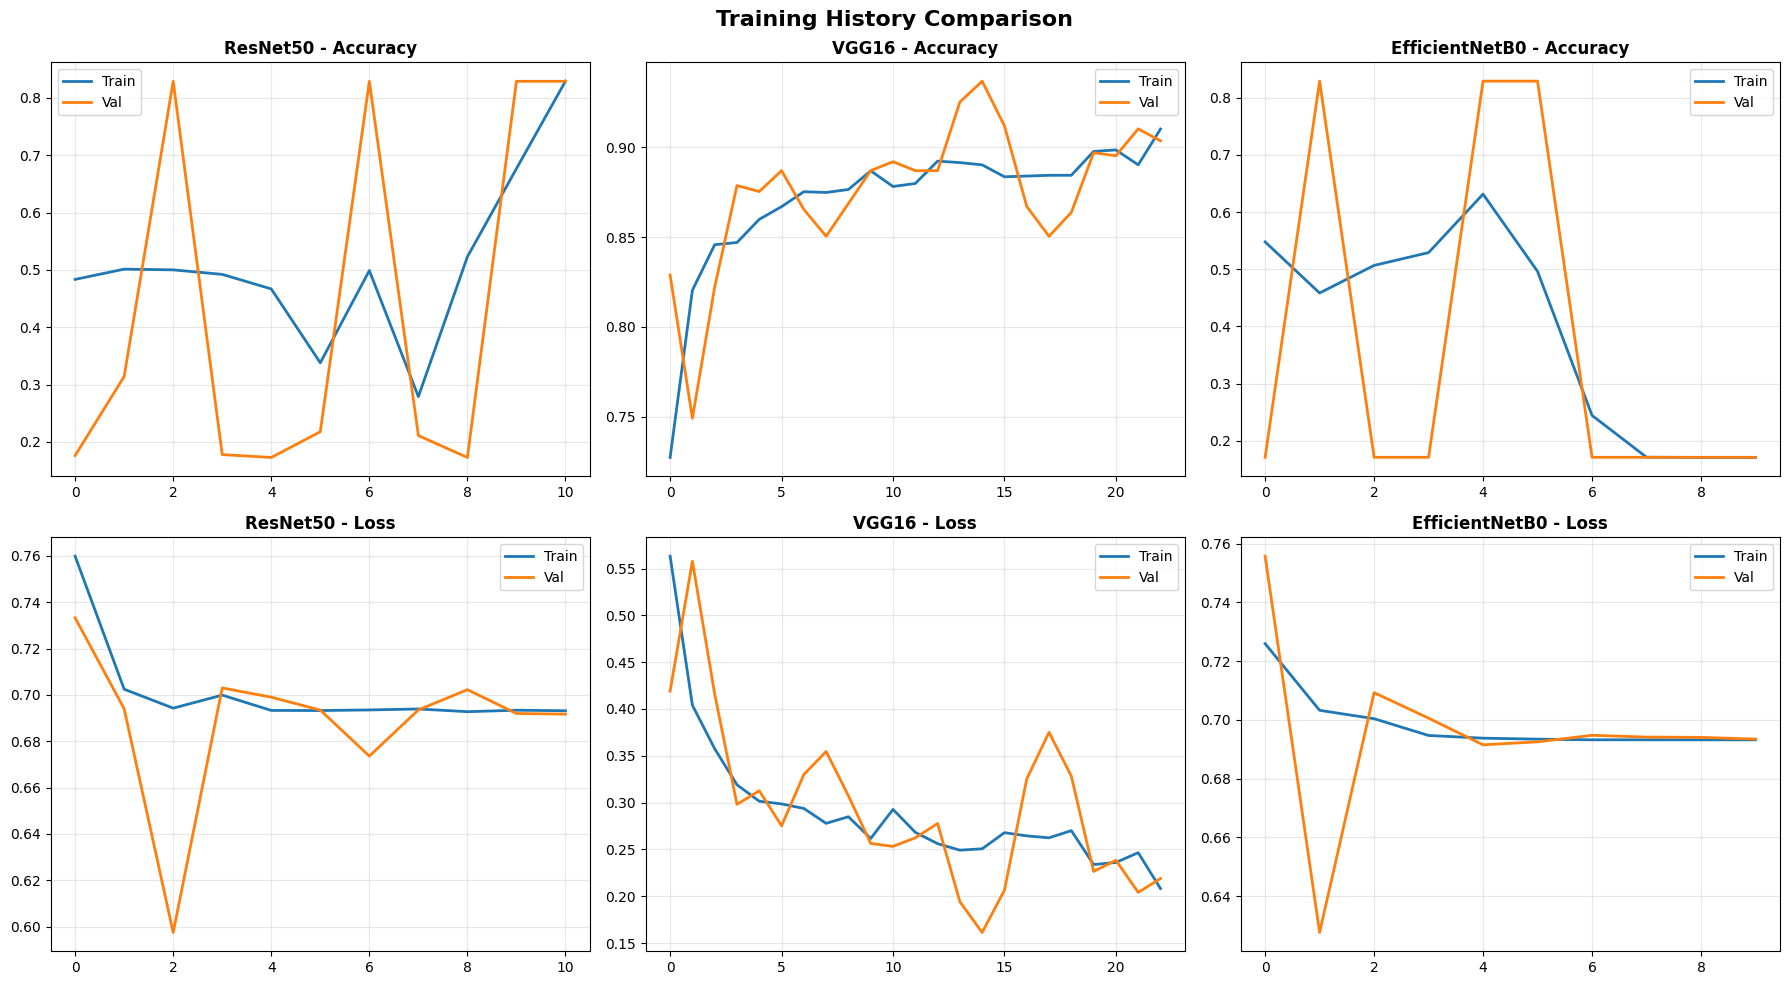

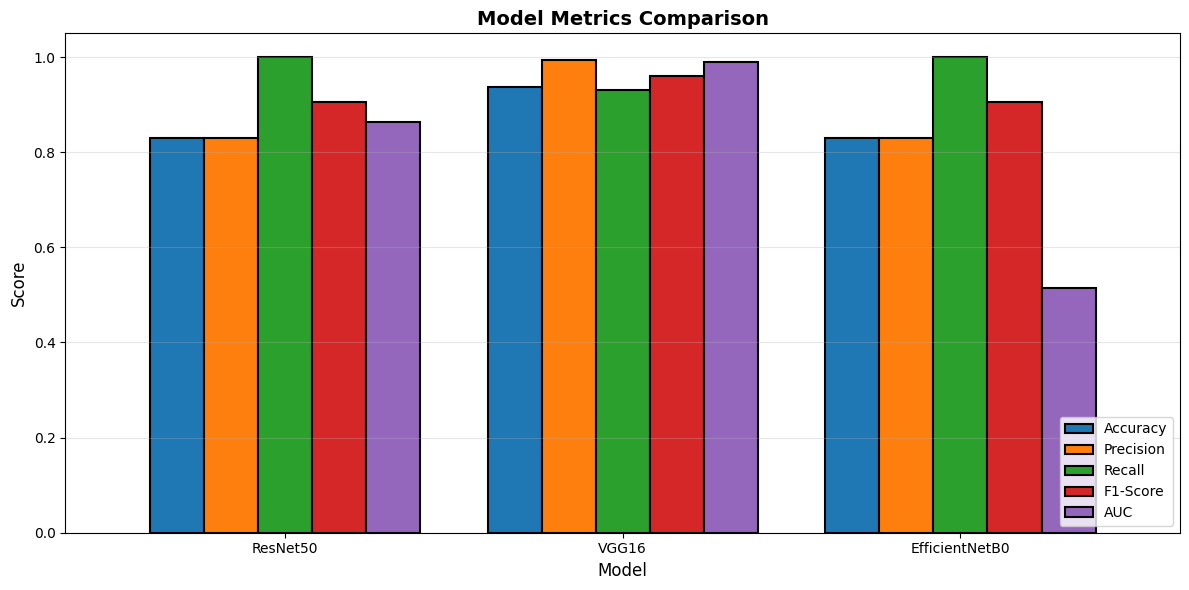

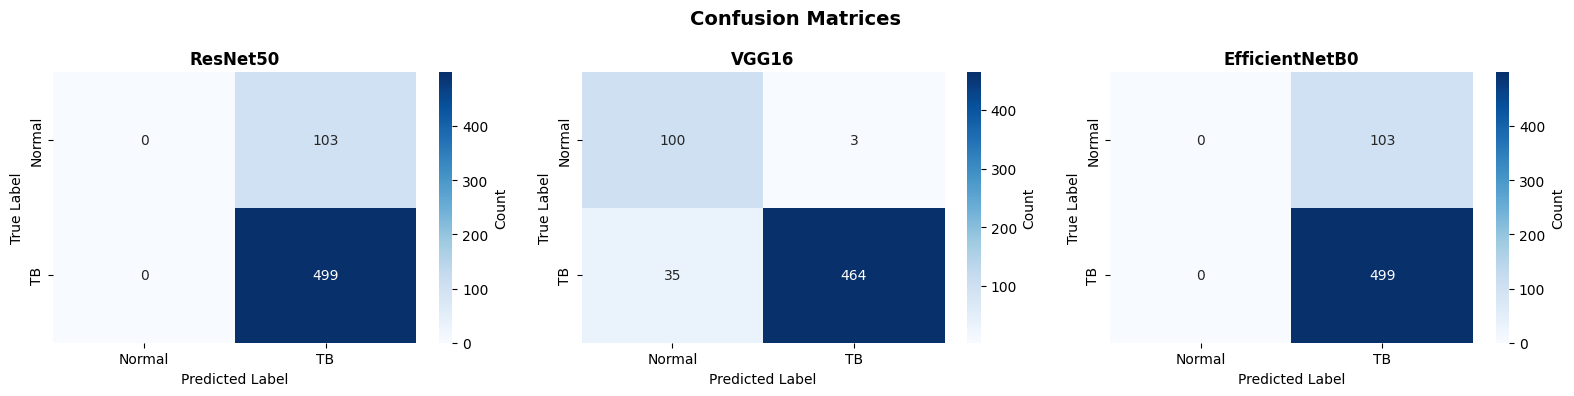

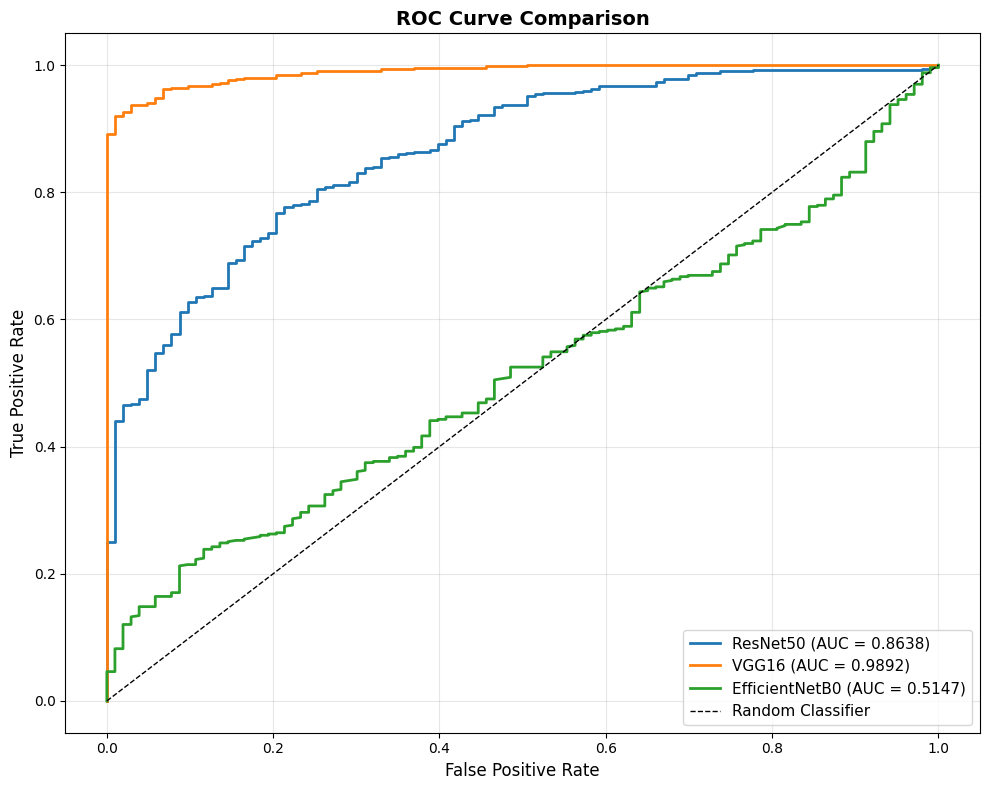

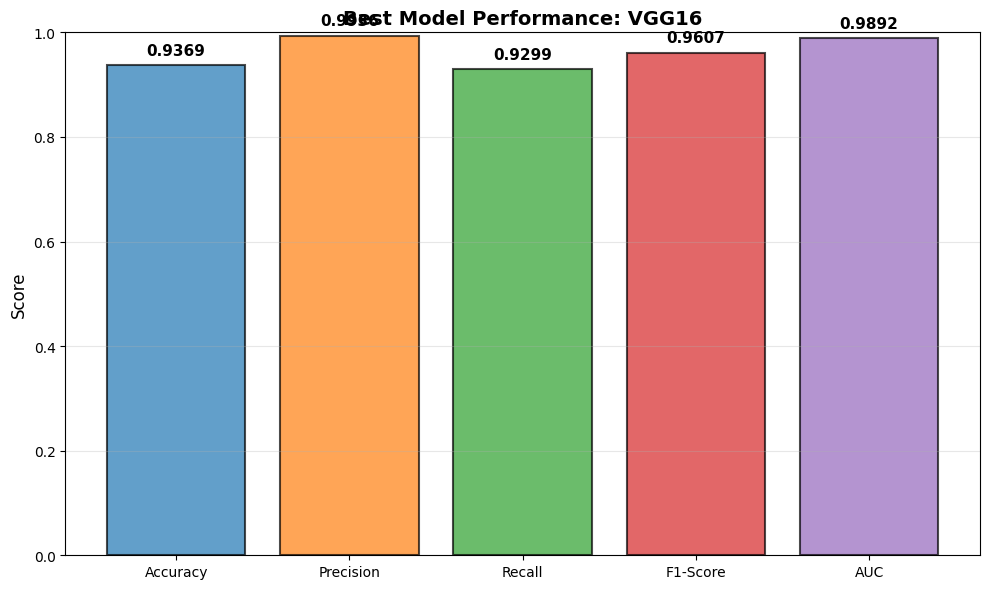


SAVING MODELS

Best Model: VGG16
   AUC: 0.9892


Saved: ResNet50_model.h5
Saved: VGG16_model.h5
Saved: EfficientNetB0_model.h5


In [ ]:
print("\nGenerating Visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training History Comparison', fontsize=16, fontweight='bold')

for idx, model_name in enumerate(models_dict.keys()):
    history = histories_dict[model_name]

    axes[0, idx].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0, idx].plot(history.history['val_accuracy'], label='Val', linewidth=2)
    axes[0, idx].set_title(f'{model_name} - Accuracy', fontweight='bold')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)

    axes[1, idx].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1, idx].plot(history.history['val_loss'], label='Val', linewidth=2)
    axes[1, idx].set_title(f'{model_name} - Loss', fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

metrics_df = pd.DataFrame(metrics_dict).T

fig, ax = plt.subplots(figsize=(12, 6))
metrics_df.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=1.5)
ax.set_title('Model Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylim([0, 1.05])
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')

for idx, model_name in enumerate(models_dict.keys()):
    y_pred = predictions_dict[model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'TB'],
                yticklabels=['Normal', 'TB'],
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{model_name}', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=100, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))

for model_name in models_dict.keys():
    y_pred_prob = predictions_dict[model_name]['y_pred_prob']
    auc = metrics_dict[model_name]['AUC']

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

best_model = max(metrics_dict, key=lambda x: metrics_dict[x]['AUC'])
best_metrics = metrics_dict[best_model]

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = ax.bar(best_metrics.keys(), best_metrics.values(), color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_ylim([0, 1])
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Best Model Performance: {best_model}', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar, (metric, val) in zip(bars, best_metrics.items()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('best_model_metrics.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("SAVING MODELS")
print("="*70)

best_model_name = max(metrics_dict, key=lambda x: metrics_dict[x]['AUC'])
print(f"\nBest Model: {best_model_name}")
print(f"   AUC: {metrics_dict[best_model_name]['AUC']:.4f}")

for model_name, model in models_dict.items():
    model.save(f'{model_name}_model.h5')
    print(f"Saved: {model_name}_model.h5")

In [ ]:
print("\n" + "="*70)
print("MODEL EVALUATION & COMPARISON")
print("="*70)

for model_name in models_dict.keys():
    y_pred = predictions_dict[model_name]['y_pred']
    y_pred_prob = predictions_dict[model_name]['y_pred_prob']

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    metrics_dict[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }

    print(f"\n{model_name} Performance:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   AUC-ROC:   {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print(f"\n   Confusion Matrix:\n{cm}")


MODEL EVALUATION & COMPARISON

ResNet50 Performance:
   Accuracy:  0.8289
   Precision: 0.8289
   Recall:    1.0000
   F1-Score:  0.9064
   AUC-ROC:   0.8638

   Confusion Matrix:
[[  0 103]
 [  0 499]]

VGG16 Performance:
   Accuracy:  0.9369
   Precision: 0.9936
   Recall:    0.9299
   F1-Score:  0.9607
   AUC-ROC:   0.9892

   Confusion Matrix:
[[100   3]
 [ 35 464]]

EfficientNetB0 Performance:
   Accuracy:  0.8289
   Precision: 0.8289
   Recall:    1.0000
   F1-Score:  0.9064
   AUC-ROC:   0.5147

   Confusion Matrix:
[[  0 103]
 [  0 499]]



Generating Visualizations...


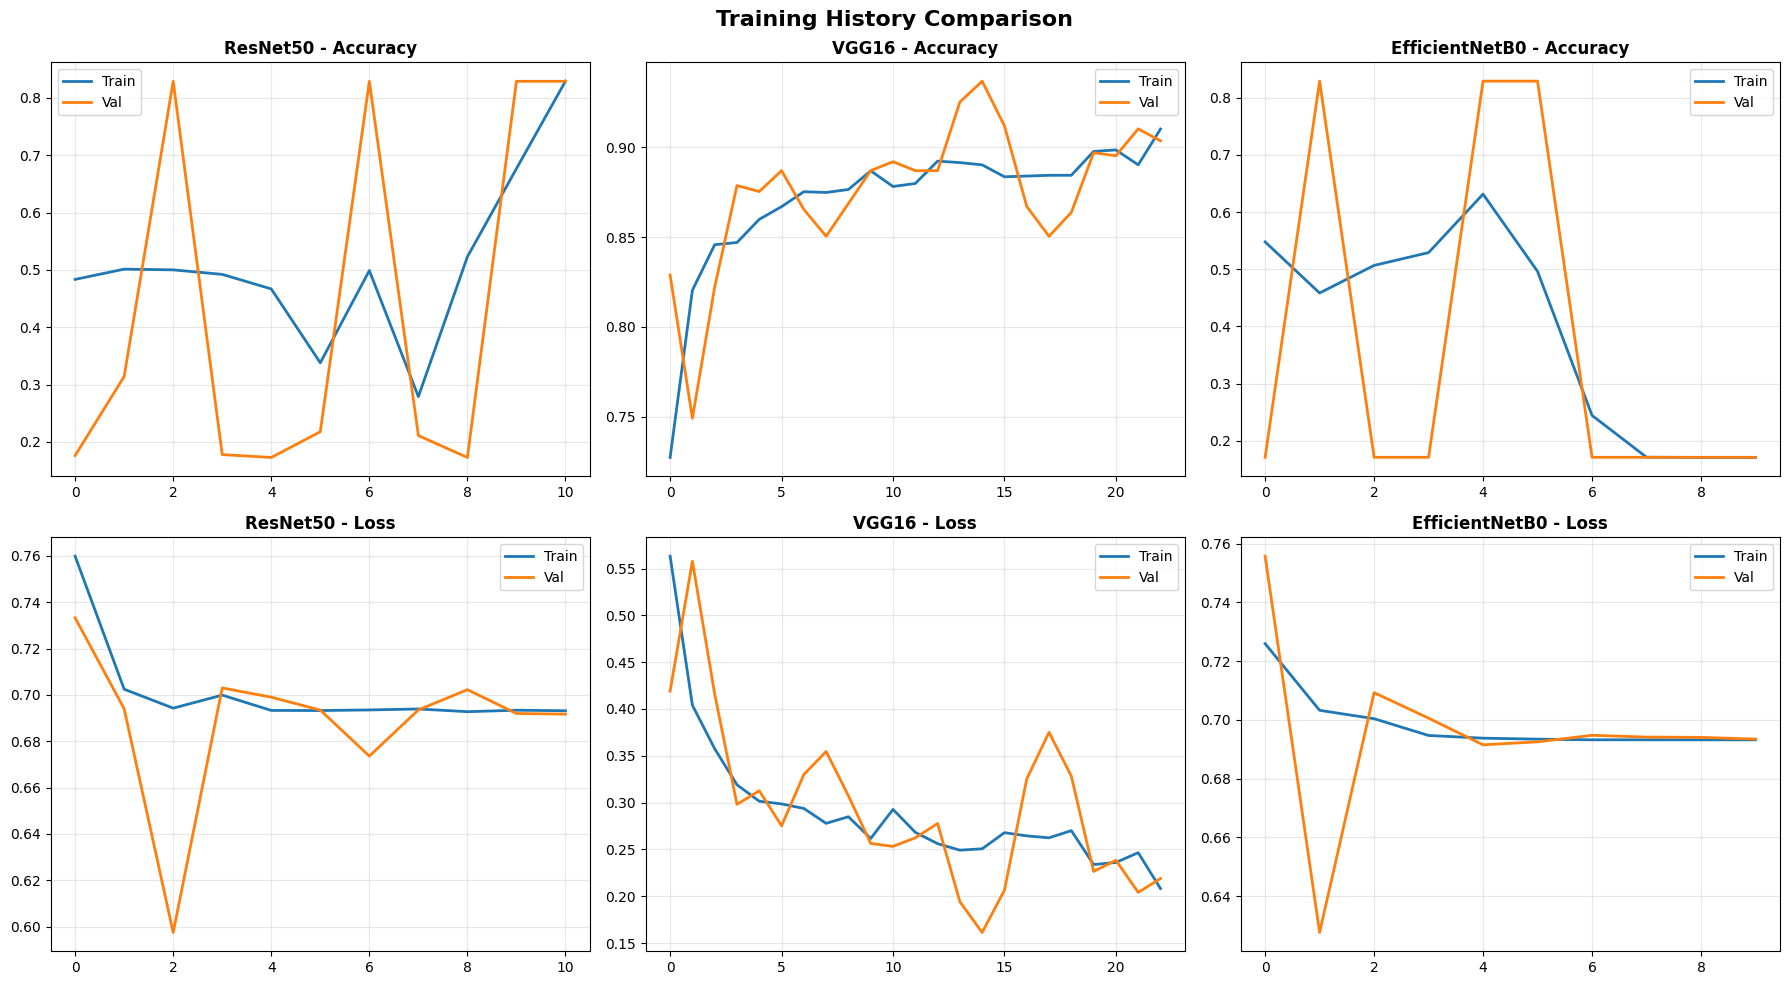

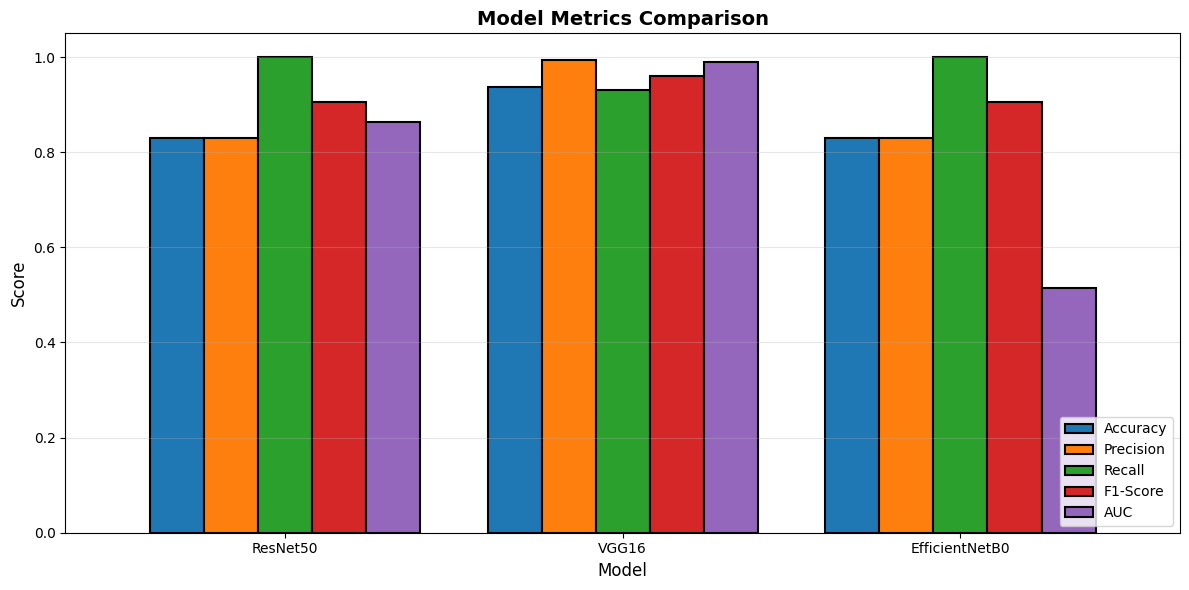

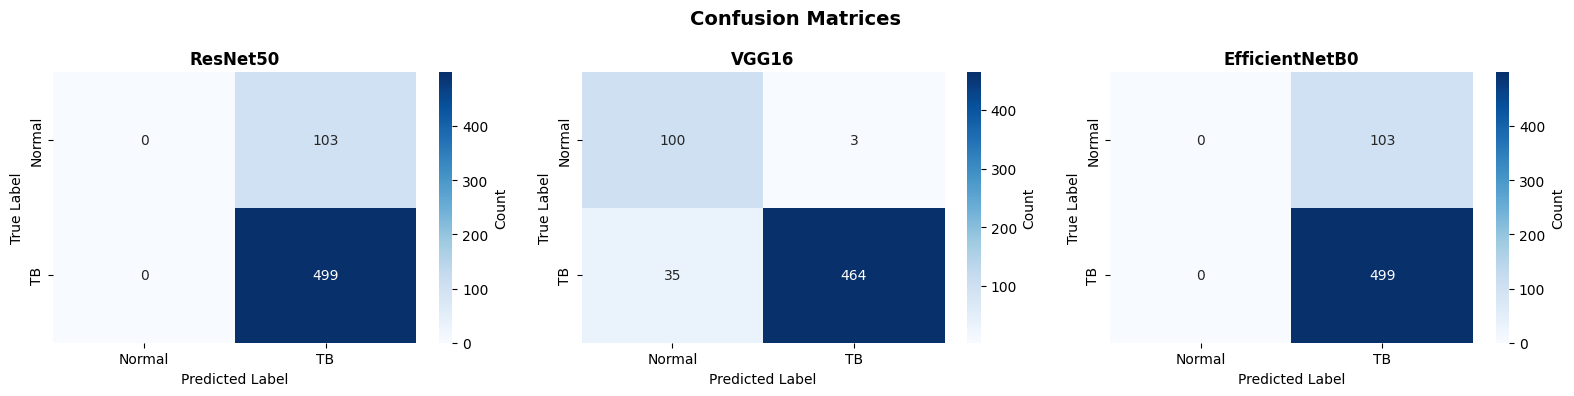

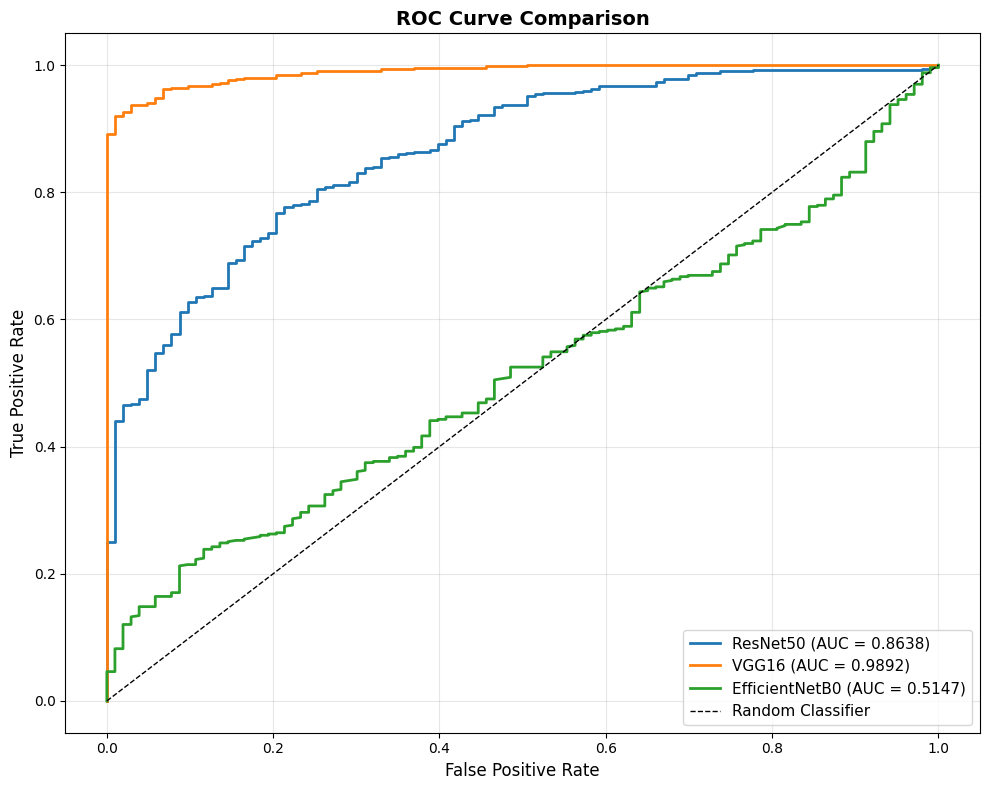

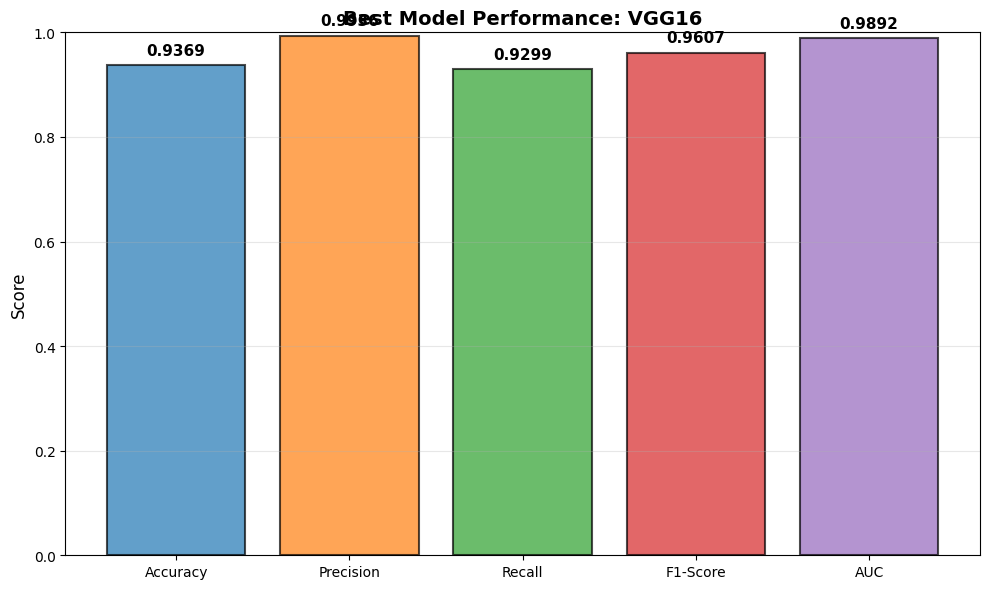


SAVING MODELS

Best Model: VGG16
   AUC: 0.9892


Saved: ResNet50_model.h5
Saved: VGG16_model.h5
Saved: EfficientNetB0_model.h5


In [ ]:
print("\nGenerating Visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training History Comparison', fontsize=16, fontweight='bold')

for idx, model_name in enumerate(models_dict.keys()):
    history = histories_dict[model_name]

    axes[0, idx].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0, idx].plot(history.history['val_accuracy'], label='Val', linewidth=2)
    axes[0, idx].set_title(f'{model_name} - Accuracy', fontweight='bold')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)

    axes[1, idx].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1, idx].plot(history.history['val_loss'], label='Val', linewidth=2)
    axes[1, idx].set_title(f'{model_name} - Loss', fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

metrics_df = pd.DataFrame(metrics_dict).T

fig, ax = plt.subplots(figsize=(12, 6))
metrics_df.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=1.5)
ax.set_title('Model Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylim([0, 1.05])
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')

for idx, model_name in enumerate(models_dict.keys()):
    y_pred = predictions_dict[model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'TB'],
                yticklabels=['Normal', 'TB'],
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{model_name}', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=100, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))

for model_name in models_dict.keys():
    y_pred_prob = predictions_dict[model_name]['y_pred_prob']
    auc = metrics_dict[model_name]['AUC']

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

best_model = max(metrics_dict, key=lambda x: metrics_dict[x]['AUC'])
best_metrics = metrics_dict[best_model]

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = ax.bar(best_metrics.keys(), best_metrics.values(), color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_ylim([0, 1])
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Best Model Performance: {best_model}', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar, (metric, val) in zip(bars, best_metrics.items()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('best_model_metrics.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("SAVING MODELS")
print("="*70)

best_model_name = max(metrics_dict, key=lambda x: metrics_dict[x]['AUC'])
print(f"\nBest Model: {best_model_name}")
print(f"   AUC: {metrics_dict[best_model_name]['AUC']:.4f}")

for model_name, model in models_dict.items():
    model.save(f'{model_name}_model.h5')
    print(f"Saved: {model_name}_model.h5")